In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
# image 장 수 확인
style = 'anime_person'
base_train_dic = f'../prompt-to-prompt/{style}'

file_list = os.listdir(base_train_dic)

len(file_list)

2151

In [4]:
import random

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None):
        self.transform = transforms_

        self.files = sorted(glob.glob(root + "/*.png"))
        self.files_clone = sorted(glob.glob(root+"/*.png"),reverse=True)
        
    def __getitem__(self, index):
        random.seed(index)
        ref_index = [random.randint(0, len(self.files_clone)-1) for _ in range(5)]
        
        img = Image.open(self.files[index % len(self.files)])
        reference_imgs = [Image.open(self.files_clone[i]) for i in ref_index]
        
        w, h = img.size
        w_clone, h_clone = reference_imgs[0].size
        
        img_A = img.crop((0, 0, w / 2, h)) # 이미지의 왼쪽 절반, origin image 
        img_B = img.crop((w / 2, 0, w, h)) # 이미지의 오른쪽 절반, style image 
        img_ref = [ref.crop((w_clone / 2, 0, w_clone, h_clone)) for ref in reference_imgs]  # 이미지의 우측, 참조 이미지
        
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)
        img_ref = [self.transform(ref) for ref in img_ref]

        img_ref = torch.cat(img_ref, dim=0)  # 참조 이미지를 채널 방향으로 연결
        
        return {"A": img_A, "B": img_B, "C": img_ref}

    def __len__(self):
        return len(self.files)

In [5]:
transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageDataset(f"../prompt-to-prompt/{style}", transforms_=transforms_)

print(len(dataset))
train_size = int(0.85*len(dataset))
test_size = len(dataset) - train_size

2151


In [6]:
from torch.utils.data.dataset import random_split

train_dataset, val_dataset = random_split(dataset, [train_size,test_size])

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

In [7]:
batch_imgs = next(iter(train_dataloader))
print(batch_imgs['A'].size())
print(batch_imgs['B'].size())
print(batch_imgs['C'].size())
#print(batch_x.shape, batch_y.shape) # batch, channel, width, height

torch.Size([10, 3, 256, 256])
torch.Size([10, 3, 256, 256])
torch.Size([10, 15, 256, 256])


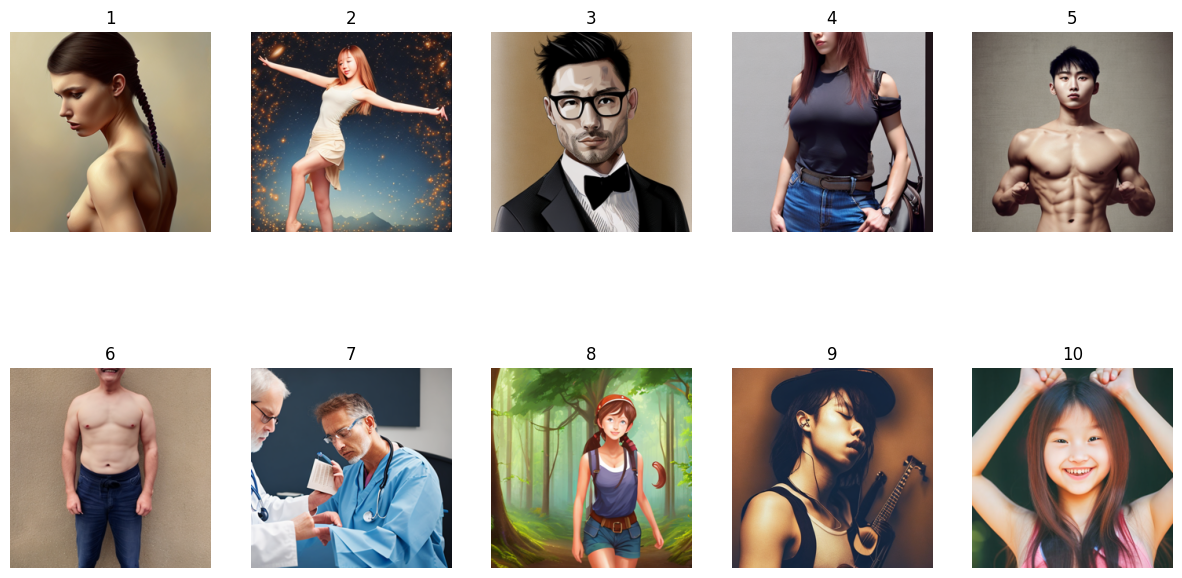

In [8]:
figure = plt.figure(figsize=(15,8))
rows, cols = 2, 5

for i in range(1, rows*cols +1):
    img_a = batch_imgs['A'][i-1]
    img_a = (img_a*0.5 + 0.5)
    img_a = img_a.permute(1,2,0)

    
    figure.add_subplot(rows, cols, i)
    plt.title(i)
    plt.axis('off')
    plt.imshow(img_a) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌
        
    
plt.show()

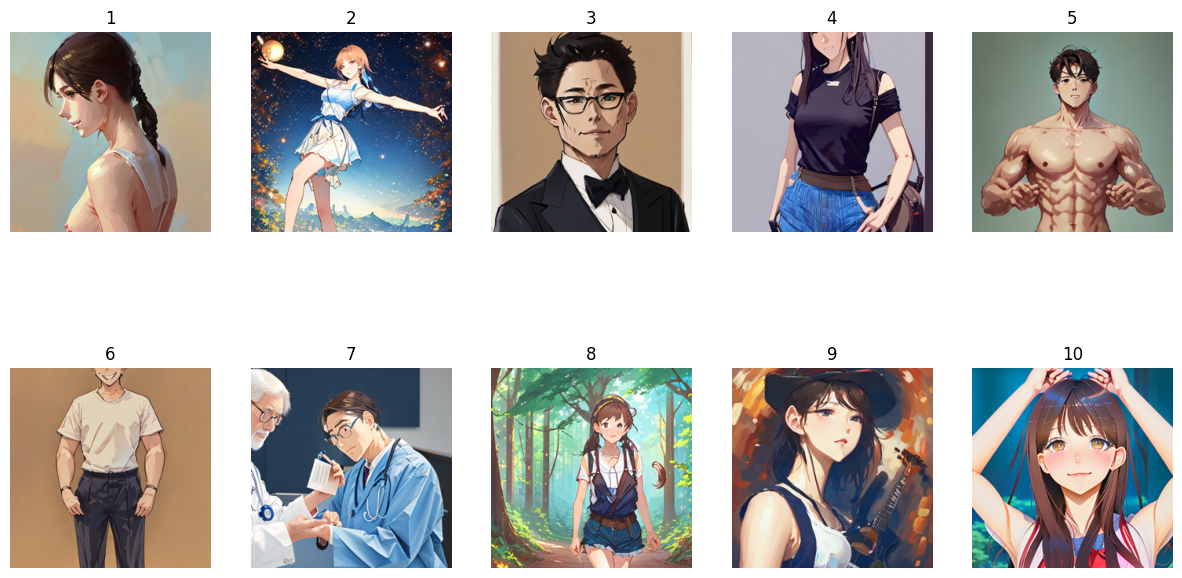

In [9]:
figure = plt.figure(figsize=(15,8))
rows, cols = 2, 5

for i in range(1, rows*cols +1):
    img_a = batch_imgs['B'][i-1]
    img_a = (img_a*0.5 + 0.5)
    img_a = img_a.permute(1,2,0)

    
    figure.add_subplot(rows, cols, i)
    plt.title(i)
    plt.axis('off')
    plt.imshow(img_a) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌
        
    
plt.show()

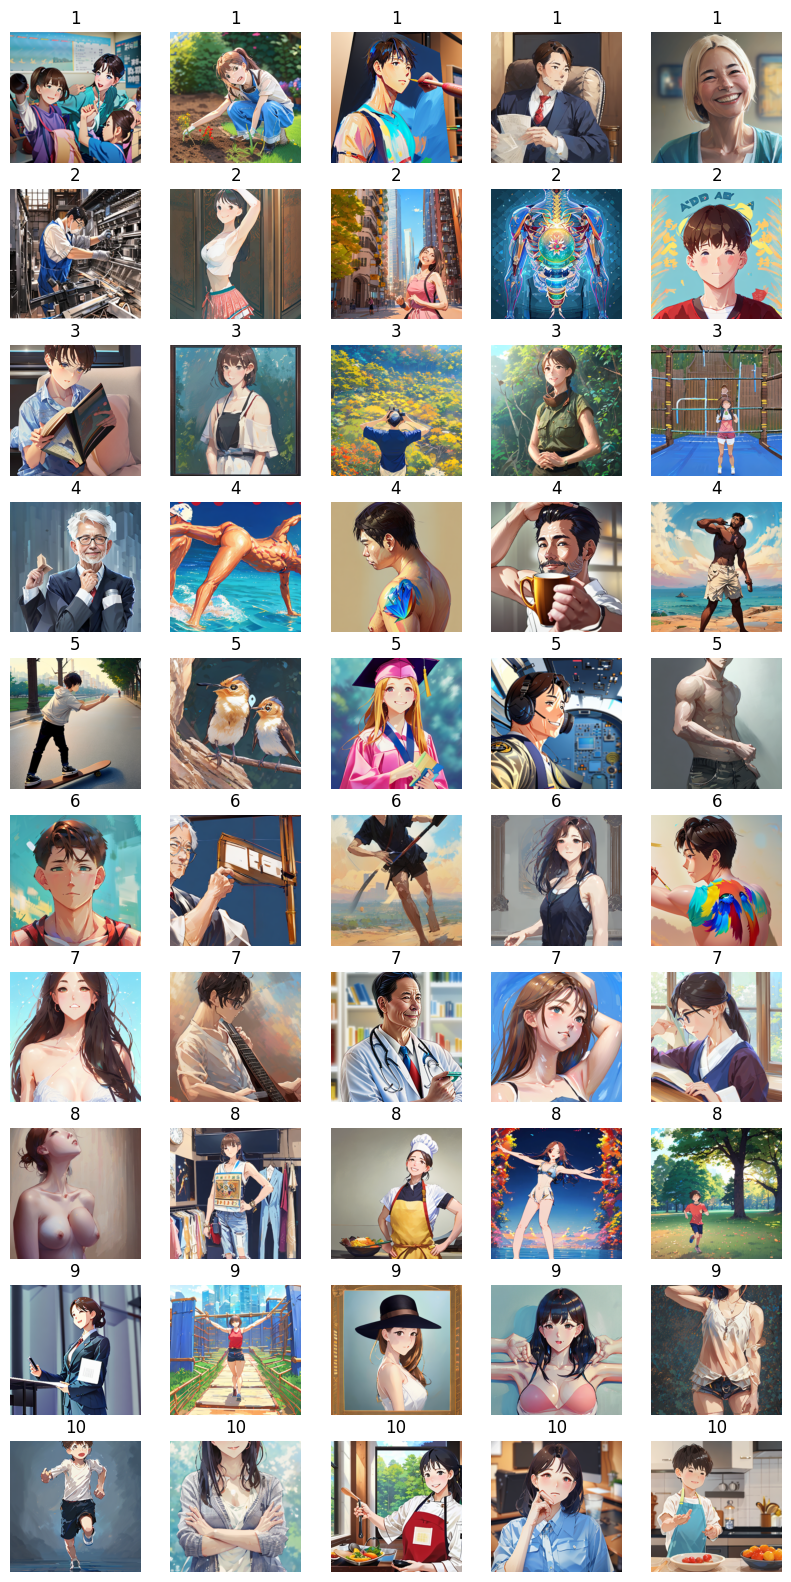

In [10]:
figure = plt.figure(figsize=(10,20))
rows, cols = 10, 5

concatenated_imgs = batch_imgs['C']
num = 1
order = 1

for i in range(1, rows +1):
    imgs = concatenated_imgs[i-1]
    for j in range(3,16,3):
        
        img_a = imgs[j-3:j]  # 이미지 추출

        img_a = (img_a * 0.5 + 0.5).permute(1, 2, 0)  # 이미지 스케일 및 차원 변경
    
        # 서브플롯트를 추가하고 이미지를 플로팅
        figure.add_subplot(rows, cols, num)
        num += 1
        plt.title(order)
        plt.axis('off')
        plt.imshow(img_a)
    order += 1
    
plt.show()

In [11]:
"""reference image(3~5) information을 UNet Decoder 단에 전달하는 model"""  
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input, style_input):
        x = self.model(x)
        x = torch.cat((x, skip_input,style_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x
        
class Conditioner(nn.Module):
    def __init__(self, in_channels=15):
        super(Conditioner, self).__init__()

        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.down1 = UNetDown(in_channels, 32, normalize = False) # 출력: [64 X 256 X 256]
        self.down2 = nn.Sequential(
            UNetDown(32,32),
            UNetDown(32,32),
            UNetDown(32, 32) # 출력: [32 X 256 X 256]
        )
        
        self.down3 = UNetDown(32, 64) # 출력: [64 X 128 X 128]
        self.down4 = nn.Sequential(
            UNetDown(64,64),
            UNetDown(64,64),
            UNetDown(64, 64) # 출력: [128 X 128 X 128]
        )
        self.down5 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down6 = nn.Sequential(
            UNetDown(128,128),
            UNetDown(128,128),
            UNetDown(128, 128) # 출력: [256 X 64 X 64]
        )
        self.down7 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down8 = nn.Sequential(
            UNetDown(256,256),
            UNetDown(256,256),
            UNetDown(256, 256) # 출력: [256 X 32 X 32]
        )
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1) #connect
        d3 = self.maxpool(d2)

        d4 = self.down3(d3)
        d5 = self.down4(d4) #connect
        d6 = self.maxpool(d5)

        d7 = self.down5(d6)
        d8 = self.down6(d7) #connect
        d9 = self.maxpool(d8)

        d10 = self.down7(d9)
        d11 = self.down8(d10) #connect

        return d2, d5, d8, d11

# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.Conditioner = Conditioner()
        
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.down1 = UNetDown(in_channels, 32, normalize = False) # 출력: [32 X 256 X 256]
        self.down2 = UNetDown(32, 32) # 출력: [32 X 256 X 256]
        
        
        self.down3 = UNetDown(32, 64) # 출력: [128 X 128 X 128]
        self.down4 = UNetDown(64, 64) # 출력: [128 X 128 X 128]
        
        self.down5 = UNetDown(64, 128) # 출력: [256 X 64 X 64]
        self.down6 = UNetDown(128, 128) # 출력: [256 X 64 X 64]
        
        self.down7 = UNetDown(128, 256) # 출력: [512 X 32 X 32]
        self.down8 = UNetDown(256, 256) # 출력: [512 X 32 X 32]

        self.middle1 = UNetDown(256,512) # 출력: [1024 x 16 x 16]
        self.middle2 = UNetDown(512,512) # 출력: [1024 x 16 x 16]
        
        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 256) # 출력: [512*3 X 32 X 32] #upsampling -> relu -> concat
        self.up2 = UNetDown(256*3,256*2) # 출력: [512*2 x 32 x 32] 
        self.up3 = UNetDown(256*2,256) # 출력: [512 x 32 x 32]
        
        self.up4 = UNetUp(256, 128) # 출력: [256*3 X 64 X 64] 
        self.up5 = UNetDown(128*3, 128*2) # 출력: [256*2 x 64 x 64]
        self.up6 = UNetDown(128*2,128) # 출력: [256 x 64 x 64]

        self.up7 = UNetUp(128, 64) # 출력: [128*3 x 128 x 128]
        self.up8 = UNetDown(64*3, 64*2) # 출력: [128*2 x 128 x 128]
        self.up9 = UNetDown(64*2, 64) # 출력: [128 x 128 x 128]

        self.up10 = UNetUp(64,32) # 출력: [64*3 x 256 x 256]
        self.up11 = UNetDown(32*3,32*2) # 출력: [64*2 x 256 x 256]
        self.up12 = UNetDown(32*2,32) # 출력: [64 x 256 x 256]
        
        self.final = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size = 3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, style_x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        c1,c2,c3,c4 = self.Conditioner(style_x)
        
        d1 = self.down1(x)
        d2 = self.down2(d1) #connect
        d3 = self.maxpool(d2)

        d4 = self.down3(d3)
        d5 = self.down4(d4) #connect
        d6 = self.maxpool(d5)

        d7 = self.down5(d6)
        d8 = self.down6(d7) #connect
        d9 = self.maxpool(d8)

        d10 = self.down7(d9)
        d11 = self.down8(d10) #connect
        d12 = self.maxpool(d11)

        d13 = self.middle1(d12)
        d14 = self.middle2(d13)
    
        d15 = self.up1(d14,d11,c4)
        d16 = self.up2(d15)
        d17 = self.up3(d16)

        d18 = self.up4(d17,d8,c3)
        d19 = self.up5(d18)
        d20 = self.up6(d19)

        d21 = self.up7(d20, d5,c2)
        d22 = self.up8(d21)
        d23 = self.up9(d22)

        d24 = self.up10(d23, d2,c1)
        d25 = self.up11(d24)
        d26 = self.up12(d25)

        return self.final(d26)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [12]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
generator = GeneratorUNet()
discriminator = Discriminator()

DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(DEVICE)
generator.to(DEVICE)
discriminator.to(DEVICE)

# 가중치(weights) 초기화
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

criterion_GAN.to(DEVICE)
criterion_pixelwise.to(DEVICE)

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

cuda:3


In [13]:
import time

n_epochs = 300 # 학습의 횟수(epoch) 설정
sample_interval = 1000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

# 변환된 이미지와 정답 이미지 사이의 L1 픽셀 단위(pixel-wise) 손실 가중치(weight) 파라미터
lambda_pixel = 10 #100

start_time = time.time()

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        real_A = batch["A"].to(DEVICE) # origin
        real_B = batch["B"].to(DEVICE) # style
        ref_C = batch["C"].to(DEVICE) # reference
        
        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0).to(DEVICE) # 진짜(real): 1
        fake = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0).to(DEVICE) # 가짜(fake): 0
        
        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A, ref_C)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        loss_D = torch.tensor(0)
        if epoch > 10 :
            """ 판별자(discriminator)를 학습합니다. """
            optimizer_D.zero_grad()
    
            # 판별자(discriminator)의 손실(loss) 값 계산
            loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
            loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
            loss_D = (loss_real + loss_fake) / 2
    
            # 판별자(discriminator) 업데이트
            loss_D.backward()
            optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["A"].to(DEVICE)
            real_B = imgs["B"].to(DEVICE)
            fake_B = generator(real_A, ref_C)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"./anime_person_unet_with_condition2(5ref_l1_10)_result/{done}.png", nrow=5, normalize=True)

            torch.save(generator.Conditioner.state_dict(),f"./anime_person_unet_with_condition2(5ref_l1_10)_{done}_weight.pt")
    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}]")

[Epoch 0/300] [D loss: 0.000000] [G pixel loss: 0.228710, adv loss: 0.36840009689331055]
[Epoch 1/300] [D loss: 0.000000] [G pixel loss: 0.239682, adv loss: 0.315850168466568]
[Epoch 2/300] [D loss: 0.000000] [G pixel loss: 0.277511, adv loss: 0.35553205013275146]
[Epoch 3/300] [D loss: 0.000000] [G pixel loss: 0.208107, adv loss: 0.27963393926620483]
[Epoch 4/300] [D loss: 0.000000] [G pixel loss: 0.232857, adv loss: 0.2571119964122772]
[Epoch 5/300] [D loss: 0.000000] [G pixel loss: 0.223048, adv loss: 0.21940195560455322]
[Epoch 6/300] [D loss: 0.000000] [G pixel loss: 0.234240, adv loss: 0.20016470551490784]
[Epoch 7/300] [D loss: 0.000000] [G pixel loss: 0.194399, adv loss: 0.17637182772159576]
[Epoch 8/300] [D loss: 0.000000] [G pixel loss: 0.226642, adv loss: 0.15820465981960297]
[Epoch 9/300] [D loss: 0.000000] [G pixel loss: 0.202064, adv loss: 0.14704328775405884]
[Epoch 10/300] [D loss: 0.000000] [G pixel loss: 0.228486, adv loss: 0.12496502697467804]
[Epoch 11/300] [D loss:

KeyboardInterrupt: 

In [ ]:
from IPython.display import Image

Image('10000.png')

In [16]:
class FeatureVisualization(nn.Module):
    def __init__(self):
        super(FeatureVisualization, self).__init__()

        self.conditioner = Conditioner()
        self.conditioner.load_state_dict(torch.load("./anime_person_unet_with_condition2(5ref_l1_10)_weight.pt"))

        for param in self.conditioner.parameters():
            param.requires_grad = False
            
        self.activate = nn.Tanh()
        
    def forward(self, x):
        f1, f2, f3, f4 = self.conditioner(x) # 32x256x256, 64x128x128, 128x64x64, 256x32x32
        c1_ = self.activate(f1)# 3x256x256 
        c2_ = self.activate(f2)# 3x128x128 
        c3_ = self.activate(f3)# 3x64x64 
        c4_ = self.activate(f4)# 3x32x32 

        return (c1_,c2_,c3_,c4_)

In [18]:
visualization = FeatureVisualization()

visualization.to(DEVICE)
visualization.eval()

FeatureVisualization(
  (conditioner): Conditioner(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (down1): UNetDown(
      (model): Sequential(
        (0): Conv2d(15, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (down2): Sequential(
      (0): UNetDown(
        (model): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): UNetDown(
        (model): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): UNetDown(
        (model): Sequential(
         

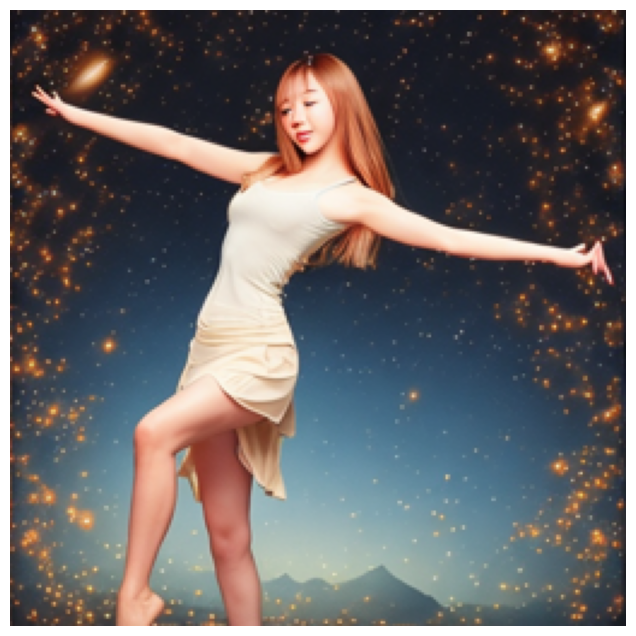

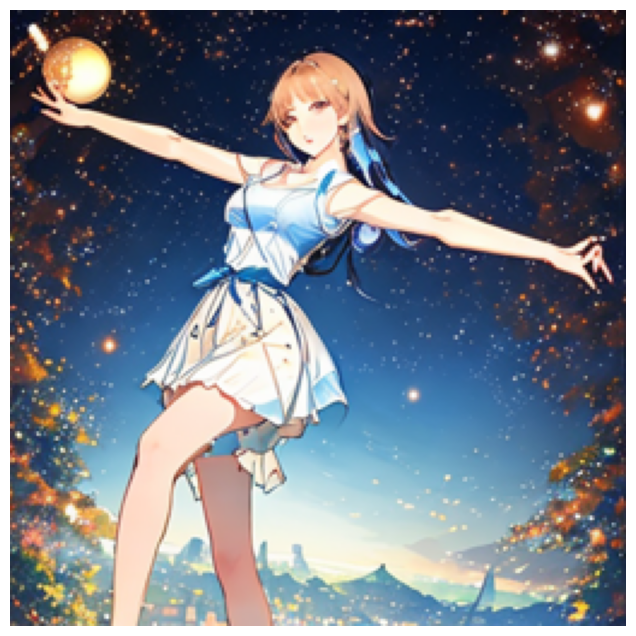

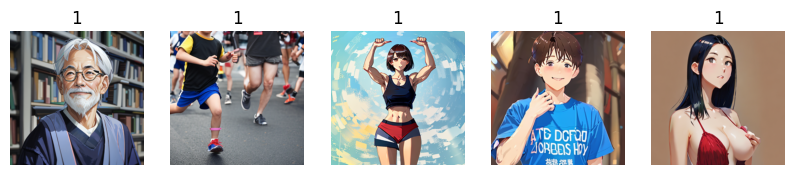

In [42]:
import os 

output_dir = "./classification/anime_person_unet_with_condition2(5ref_l1_10)_result/feature_map_imgs"

batch = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
# 모델의 입력(input) 데이터 불러오기
concatenated_imgs = batch["C"].to(DEVICE) # reference

c1, c2, c3, c4 = visualization(ref_C)
os.makedirs(output_dir, exist_ok = True)

figure = plt.figure(figsize=(15,8))
rows, cols = 1, 1

index = 2

img_a = batch_imgs['A'][index-1]
img_a = (img_a*0.5 + 0.5)
img_a = img_a.permute(1,2,0)


figure.add_subplot(rows, cols, 1)
plt.axis('off')
plt.imshow(img_a) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌
    

plt.show()

figure = plt.figure(figsize=(15,8))
rows, cols = 1, 1


img_a = batch_imgs['B'][index-1]
img_a = (img_a*0.5 + 0.5)
img_a = img_a.permute(1,2,0)


figure.add_subplot(rows, cols, 1)
plt.axis('off')
plt.imshow(img_a) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌
    
    
plt.show()

concatenated_imgs = concatenated_imgs.cpu()

figure = plt.figure(figsize=(10,20))
rows, cols = 1, 5

num = 1
order = 1


imgs = concatenated_imgs[index-1]
for j in range(3,16,3):
    
    img_a = imgs[j-3:j]  # 이미지 추출

    img_a = (img_a * 0.5 + 0.5).permute(1, 2, 0)  # 이미지 스케일 및 차원 변경

    # 서브플롯트를 추가하고 이미지를 플로팅
    figure.add_subplot(rows, cols, num)
    num += 1
    plt.title(order)
    plt.axis('off')
    plt.imshow(img_a)
order += 1
    
plt.show()



In [45]:
for channel in range(c2.size(1)):
    try:
        channel_images = c2[index-1,channel, :, :].unsqueeze(0)
        save_image(channel_images, os.path.join(output_dir, f"c2_{channel}.png"))
    except:
        pass

In [15]:
class Classifier(nn.Module):
    def __init__(self, num_class = 1):
        super(Classifier, self).__init__()

        self.conditioner = Conditioner()
        self.conditioner.load_state_dict(torch.load("./anime_person_unet_with_condition2(5ref_l1_10)_weight.pt"))

        for param in self.conditioner.parameters():
            param.requires_grad = False
            
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)

        self.adaptpool = nn.AdaptiveAvgPool2d(1)
        self.activate = nn.LeakyReLU(0.2)
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
            
        
        )
        self.style_extraction = nn.Linear(16+32+64+128, 256)
        self.classifier = nn.Linear(256, num_class)

        
    def forward(self, x):
        f1, f2, f3, f4 = self.conditioner(x) # 32x256x256, 64x128x128, 128x64x64, 256x32x32
        c1_ = self.adaptpool(self.activate(self.conv1(f1))) # 16x256x256 -> 16 x 1 x 1
        c2_ = self.adaptpool(self.activate(self.conv2(f2))) # 32x128x128 -> 32 x 1 x 1
        c3_ = self.adaptpool(self.activate(self.conv3(f3))) # 64x64x64 -> 64 x 1 x 1
        c4_ = self.adaptpool(self.activate(self.conv4(f4))) # 128x32x32 -> 128 x 1 x 1

        #batch 고려
        c1, c2, c3, c4 = torch.squeeze(c1_, (2,3)), torch.squeeze(c2_, (2,3)), torch.squeeze(c3_, (2,3)), torch.squeeze(c4_, (2,3))

        vector = torch.cat((c1,c2,c3,c4),1)
        style_vector = self.activate(self.style_extraction(vector))
        class_vector = self.classifier(style_vector)

        return class_vector, (c1_,c2_,c3_,c4_)

In [ ]:
n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 1000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정

for epoch in range(n_epochs):
    for i, batch in enumerate(train_dataloader):
        # 모델의 입력(input) 데이터 불러오기
        ref_C = batch["C"].to(DEVICE) # reference
        
        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성 (너바와 높이를 16씩 나눈 크기)
        real = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(1.0).to(DEVICE) # 진짜(real): 1
        fake = torch.FloatTensor(real_A.size(0), 1, 16, 16).fill_(0.0).to(DEVICE) # 가짜(fake): 0
        
        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 이미지 생성
        fake_B = generator(real_A, ref_C)

        # 생성자(generator)의 손실(loss) 값 계산
        loss_GAN = criterion_GAN(discriminator(fake_B, real_A), real)

        # 픽셀 단위(pixel-wise) L1 손실 값 계산
        loss_pixel = criterion_pixelwise(fake_B, real_B) 

        # 최종적인 손실(loss)
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        # 생성자(generator) 업데이트
        loss_G.backward()
        optimizer_G.step()

        loss_D = torch.tensor(0)
        if epoch > 10 :
            """ 판별자(discriminator)를 학습합니다. """
            optimizer_D.zero_grad()
    
            # 판별자(discriminator)의 손실(loss) 값 계산
            loss_real = criterion_GAN(discriminator(real_B, real_A), real) # 조건(condition): real_A
            loss_fake = criterion_GAN(discriminator(fake_B.detach(), real_A), fake)
            loss_D = (loss_real + loss_fake) / 2
    
            # 판별자(discriminator) 업데이트
            loss_D.backward()
            optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            imgs = next(iter(val_dataloader)) # 10개의 이미지를 추출해 생성
            real_A = imgs["A"].to(DEVICE)
            real_B = imgs["B"].to(DEVICE)
            fake_B = generator(real_A, ref_C)
            # real_A: 조건(condition), fake_B: 변환된 이미지(translated image), real_B: 정답 이미지
            img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2) # 높이(height)를 기준으로 이미지를 연결하기
            save_image(img_sample, f"./anime_person_unet_with_condition2(5ref_l1_10)_result/{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {loss_D.item():.6f}] [G pixel loss: {loss_pixel.item():.6f}, adv loss: {loss_GAN.item()}]")

In [ ]:
22000